# **Digit Dataset QNN**
*Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dra. Jimena Olveres Montiel
* Dr. Boris Escalante Ramírez

### Creado por: **Sebastián González Juárez**

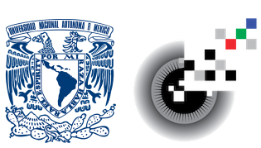

## **1) Importaciones.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pennylane as qml
from pennylane import numpy as qnp

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Semillas para reproducibilidad:

In [38]:
NP_SEED = 123
QNP_SEED = 123
np.random.seed(NP_SEED)
qnp.random.seed(QNP_SEED)

In [39]:
print(qml.__version__)

0.42.3


## **2) Parámetros globales y selección de clases.** (Editable)
En la siguiente celda escogemos que digitos queremos comparar:

In [40]:
CLASES = (2, 7)

In [41]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

Malla 4x4 => 16 qubits

In [42]:
N_ROWS, N_COLS = 4, 4
N_QUBITS = N_ROWS * N_COLS

Ansatz HEA: capas

In [43]:
N_LAYERS = 4   # ajustable

Optimizador:

In [44]:
LEARNING_RATE = 0.05
EPOCHS = 15
BATCH_SIZE = 32

In [45]:
print(f"Comparando clases: {CLASES[0]} vs {CLASES[1]}")
print(f"Qubits: {N_QUBITS} (grid {N_ROWS}x{N_COLS}), Capas HEA: {N_LAYERS}")

Comparando clases: 2 vs 7
Qubits: 16 (grid 4x4), Capas HEA: 4


## **3) Conectividad 2D y patrón brickwork**.

Rejilla y numeración de wires:

In [46]:
def rc_to_wire(r, c, n_cols):
    return r * n_cols + c

Aristas horizontales y verticales tipo brickwork:

In [47]:
def horizontal_edges(n_rows, n_cols, offset=0):
    edges = []
    for r in range(n_rows):
        for c in range(offset, n_cols - 1, 2):
            a = rc_to_wire(r, c, n_cols)
            b = rc_to_wire(r, c + 1, n_cols)
            edges.append((a, b))
    return edges

def vertical_edges(n_rows, n_cols, offset=0):
    edges = []
    for c in range(n_cols):
        for r in range(offset, n_rows - 1, 2):
            a = rc_to_wire(r, c, n_cols)
            b = rc_to_wire(r + 1, c, n_cols)
            edges.append((a, b))
    return edges

Patrón de 4 sub-pasadas por capa (brickwork)

In [48]:
PATTERN = [
    ("H", 0),  # horizontales con offset 0
    ("V", 0),  # verticales   con offset 0
    ("H", 1),  # horizontales con offset 1
    ("V", 1),  # verticales   con offset 1
]

## **4) Datos: digits 8×8 → 4×4 (average pooling 2×2) → ángulos RY.**

a) Cargar y filtrar:

In [49]:
digits = load_digits()
X_imgs, y_full = digits.images, digits.target

mask = np.isin(y_full, CLASES)
X_imgs = X_imgs[mask]
y_full = y_full[mask]

b) Etiquetas binarias: clase[0] -> 0, clase[1] -> 1:

In [50]:
y_bin = (y_full == CLASES[1]).astype(int)

c) Average pooling 8x8 -> 4x4 (promedio por bloques 2x2):

In [51]:
def avg_pool_2x2(img_8x8):
    img = img_8x8.reshape(8, 8)
    pooled = img.reshape(4, 2, 4, 2).mean(axis=(1, 3))
    return pooled

In [52]:
X_4x4 = np.array([avg_pool_2x2(im) for im in X_imgs])

d) Escalado a [0,1] y mapeo a [0, π] para RY:

In [53]:
X_min, X_max = X_4x4.min(), X_4x4.max()
X_scaled = (X_4x4 - X_min) / (X_max - X_min + 1e-8)
X_angles = np.pi * X_scaled  # ángulos RY

e) Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X_angles, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_bin
)

## **5) Device PennyLane y helpers de modelo.**

Para este caso usaremos lightning.qubit para probarlo y acelerar.

In [55]:
try:
    dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
    print("Backend: lightning.qubit")
except Exception:
    dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
    print("Backend: default.qubit")

Backend: lightning.qubit


**Feature map**

Se aplica RY(theta) en cada wire según malla 4x4: 
   
    angles_4x4: array (4,4) con ángulos en [0, π].

In [56]:
def feature_map_ry(angles_4x4):
    for r in range(N_ROWS):
        for c in range(N_COLS):
            w = rc_to_wire(r, c, N_COLS)
            qml.RY(angles_4x4[r, c], wires=w)

**Ansatz HEA**

Este Ansatz cuenta con lo siguiente:
- Rotaciones locales Rx, Rz por qubit. (Obs. antes usabamos Ry y Rz)
- Entrelazamiento patrón brickwork por CNOT.

Nustros parámetros cuánticos actulizables serán:  params_rx, params_rz: arrays (N_QUBITS,)

In [57]:
def hea_layer(params_rx, params_rz):
    # Rotaciones locales
    for q in range(N_QUBITS):
        qml.RX(params_rx[q], wires=q)
        qml.RZ(params_rz[q], wires=q)

    # Entrelazamiento por sub-patrones
    for kind, off in PATTERN:
        edges = horizontal_edges(N_ROWS, N_COLS, off) if kind == "H" \
                else vertical_edges(N_ROWS, N_COLS, off)
        for a, b in edges:
            qml.CNOT(wires=[a, b])

Parámetros entrenables como (layers, 2, n_qubits): [rx, rz]::

In [58]:
PARAM_SHAPE = (N_LAYERS, 2, N_QUBITS)
print("PARAM_SHAPE:", PARAM_SHAPE)

PARAM_SHAPE: (4, 2, 16)


## **6) QNode del modelo (expectativa Z en wire 0) y utilidades.**

In [59]:
@qml.qnode(dev)
def qnode_model(angles_4x4, theta):
    """
    angles_4x4: (4,4) -> RY por wire
    theta: (L, 2, N) -> por capa, Rx y Rz por qubit
    Salida: <Z_0>
    """
    feature_map_ry(angles_4x4)
    for l in range(theta.shape[0]):
        rx = theta[l, 0, :]
        rz = theta[l, 1, :]
        hea_layer(rx, rz)
    return qml.expval(qml.PauliZ(0))

Predicción de probabilidad de clase 1 a partir de z_vec y capa de lectura clásica.

In [60]:
def prob_y1_from_expvalZ(exp_z):
    # p(y=1) = (1 - <Z>)/2
    return (1.0 - exp_z) / 2.0

In [61]:
def forward_proba(theta, X):
    """
    Evalúa el modelo para un batch X (lista/array de (4,4)).
    Devuelve p(y=1) por muestra.
    """
    ps = []
    for img in X:
        ez = qnode_model(img, theta)
        ps.append(prob_y1_from_expvalZ(ez))
    return qnp.array(ps, dtype=qnp.float64)

In [62]:
def bce_loss(theta, Xb, yb, l2=1e-4):
    """
    Binary Cross Entropy con regularización L2 para estabilidad.
    """
    p = qnp.clip(forward_proba(theta, Xb), 1e-6, 1-1e-6)
    loss = -(yb*qnp.log(p) + (1-yb)*qnp.log(1-p)).mean()
    if l2 > 0:
        loss = loss + l2 * qnp.sum(theta*theta) / theta.size
    return loss

In [63]:
def accuracy(theta, Xb, yb):
    p = forward_proba(theta, Xb)
    yhat = (p >= 0.5).astype(int)
    return float(accuracy_score(yb, yhat))

## **7) Entrenamiento (Adam) con mini-batches**

In [64]:
opt = qml.AdamOptimizer(stepsize=LEARNING_RATE)

In [65]:
# Inicialización pequeña alrededor de 0
theta = 0.1 * qnp.random.uniform(low=-1.0, high=1.0, size=PARAM_SHAPE, requires_grad=True)

In [66]:
def iterate_minibatches(X, y, batch_size, shuffle=True, seed=NP_SEED):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(X))
    if shuffle:
        rng.shuffle(idx)
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        sel = idx[start:end]
        yield X[sel], y[sel]

In [67]:
hist = {"loss": [], "acc_tr": [], "acc_te": []}

In [68]:
for epoch in range(1, EPOCHS+1):
    # Una época de entrenamiento
    for Xb, yb in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True, seed=epoch+NP_SEED):
        theta = opt.step(lambda th: bce_loss(th, Xb, yb), theta)

    # Métricas por época
    l_tr = float(bce_loss(theta, X_train, y_train))
    a_tr = accuracy(theta, X_train, y_train)
    a_te = accuracy(theta, X_test,  y_test)

    hist["loss"].append(l_tr)
    hist["acc_tr"].append(a_tr)
    hist["acc_te"].append(a_te)

    print(f"Epoch {epoch:02d} | loss={l_tr:.4f} | acc_tr={a_tr:.3f} | acc_te={a_te:.3f}")

Epoch 01 | loss=1.0161 | acc_tr=0.496 | acc_te=0.500
Epoch 02 | loss=0.7048 | acc_tr=0.496 | acc_te=0.500
Epoch 03 | loss=0.5563 | acc_tr=0.894 | acc_te=0.889
Epoch 04 | loss=0.4714 | acc_tr=0.912 | acc_te=0.764
Epoch 05 | loss=0.4510 | acc_tr=0.947 | acc_te=0.875
Epoch 06 | loss=0.4291 | acc_tr=0.937 | acc_te=0.861
Epoch 07 | loss=0.4164 | acc_tr=0.951 | acc_te=0.861
Epoch 08 | loss=0.4101 | acc_tr=0.944 | acc_te=0.861
Epoch 09 | loss=0.4068 | acc_tr=0.940 | acc_te=0.861
Epoch 10 | loss=0.4052 | acc_tr=0.947 | acc_te=0.875
Epoch 11 | loss=0.4041 | acc_tr=0.937 | acc_te=0.889
Epoch 12 | loss=0.4040 | acc_tr=0.947 | acc_te=0.875
Epoch 13 | loss=0.4032 | acc_tr=0.937 | acc_te=0.903
Epoch 14 | loss=0.4033 | acc_tr=0.940 | acc_te=0.889
Epoch 15 | loss=0.4035 | acc_tr=0.937 | acc_te=0.889


## **8) Curvas de entrenamiento.**

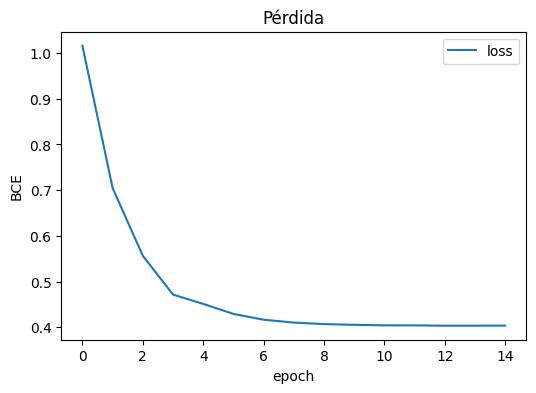

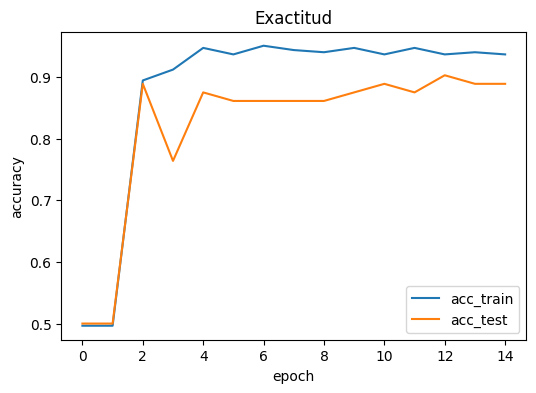

In [69]:
plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="loss")
plt.xlabel("epoch"); plt.ylabel("BCE"); plt.title("Pérdida")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["acc_tr"], label="acc_train")
plt.plot(hist["acc_te"], label="acc_test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Exactitud")
plt.legend(); plt.show()

## **9) Evaluación final.**

In [70]:
probs_te = np.array(forward_proba(theta, X_test))
y_pred = (probs_te >= 0.5).astype(int)

print("Matriz de confusión (test):")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación (test):")
print(classification_report(
    y_test, y_pred,
    target_names=[f"{CLASES[0]}→0", f"{CLASES[1]}→1"]
))

Matriz de confusión (test):
[[31  5]
 [ 3 33]]

Reporte de clasificación (test):
              precision    recall  f1-score   support

         2→0       0.91      0.86      0.89        36
         7→1       0.87      0.92      0.89        36

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72



## **10) Dibujos de circuito (feature map SOLO y ansatz SOLO)**

In [71]:
# QNode SOLO feature map (para dibujar)
@qml.qnode(dev)
def qnode_feature_only(angles_4x4):
    feature_map_ry(angles_4x4)
    return qml.expval(qml.PauliZ(0))

# QNode SOLO una capa HEA (param = 0) sobre estado base |0...0> (para conectividad)
@qml.qnode(dev)
def qnode_hea_one_layer():
    rx = qnp.zeros((N_QUBITS,))
    rz = qnp.zeros((N_QUBITS,))
    hea_layer(rx, rz)
    return qml.expval(qml.PauliZ(0))

# Mostrar
sample = X_train[0]

print("\n=== Circuito: FEATURE MAP (RY por malla 4x4) ===")
print(qml.draw(qnode_feature_only)(sample))

print("\n=== Circuito: 1 capa HEA (brickwork, Rx/Rz con 0) ===")
print(qml.draw(qnode_hea_one_layer)())


=== Circuito: FEATURE MAP (RY por malla 4x4) ===
 0: ──RY(0.69)─┤  <Z>
 1: ──RY(2.95)─┤     
 2: ──RY(0.15)─┤     
 3: ──RY(0.00)─┤     
 4: ──RY(0.25)─┤     
 5: ──RY(2.60)─┤     
 6: ──RY(0.39)─┤     
 7: ──RY(0.00)─┤     
 8: ──RY(0.00)─┤     
 9: ──RY(2.55)─┤     
10: ──RY(0.20)─┤     
11: ──RY(0.00)─┤     
12: ──RY(0.05)─┤     
13: ──RY(3.14)─┤     
14: ──RY(2.85)─┤     
15: ──RY(0.64)─┤     

=== Circuito: 1 capa HEA (brickwork, Rx/Rz con 0) ===
 0: ──RX(0.00)──RZ(0.00)─╭●─╭●─────────────────────────┤  <Z>
 1: ──RX(0.00)──RZ(0.00)─╰X─│──╭●────╭●────────────────┤     
 2: ──RX(0.00)──RZ(0.00)─╭●─│──│──╭●─╰X────────────────┤     
 3: ──RX(0.00)──RZ(0.00)─╰X─│──│──│──╭●────────────────┤     
 4: ──RX(0.00)──RZ(0.00)─╭●─╰X─│──│──│─────╭●──────────┤     
 5: ──RX(0.00)──RZ(0.00)─╰X────╰X─│──│──╭●─│──╭●───────┤     
 6: ──RX(0.00)──RZ(0.00)─╭●───────╰X─│──╰X─│──│──╭●────┤     
 7: ──RX(0.00)──RZ(0.00)─╰X──────────╰X────│──│──│──╭●─┤     
 8: ──RX(0.00)──RZ(0.00)─╭●─╭●─────────────╰X─│